<a href="https://colab.research.google.com/github/dtoralg/INESDI_Data-Science_ML_IA/blob/main/%5B05%5D%20-%20Arboles%20de%20decision/Evaluacion_y_Optimizacion_Largo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluacion y Optimización de Modelos - Ejercicio 8: Evaluacion_y_Optimizacion_Largo.ipynb

Este notebook es **We do**: lo hacemos juntos. Algunas celdas están resueltas para guiarte en las partes complejas, pero encontrarás comentarios `# TODO` dentro del código que debes completar durante la sesión. Ejecuta las celdas en orden, experimenta con los parámetros y anota tus decisiones.

## Objetivos

- Dataset Titanic de OpenML
- Limpieza y preparación de datos
- Búsqueda de hiperparámetros
- Regularización y Early Stopping
- Validación y detección de overfitting
- Métricas de evaluación

In [ ]:
!pip install scikit-optimize lightgbm

In [ ]:
# Librerías y configuración (resuelto)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import validation_curve, learning_curve
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de gráficos
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

# Intentar importar librerías opcionales
try:
    import xgboost as xgb
    xgboost_available = True
except ImportError:
    print("XGBoost no disponible. Instala con: pip install xgboost")
    xgboost_available = False

try:
    import lightgbm as lgb
    lightgbm_available = True
except ImportError:
    print("LightGBM no disponible. Instala con: pip install lightgbm")
    lightgbm_available = False

try:
    from skopt import BayesSearchCV
    from skopt.space import Real, Integer
    bayesian_available = True
except ImportError:
    print("Para optimización bayesiana, instala: pip install scikit-optimize")
    bayesian_available = False

### Carga de datos y preparación

Cargar dataset Titanic (dataset estándar y reproducible)

In [ ]:
print("Cargando dataset Titanic desde OpenML...")

# Cargar dataset Titanic (dataset estándar y reproducible)
titanic = fetch_openml('titanic', version=1, as_frame=True)
df = titanic.frame

print(f"Dataset cargado. Shape: {df.shape}")
print(f"Columnas disponibles: {list(df.columns)}")
print(f"\nPrimeras 5 filas:")
print(df.head())

Cargando dataset Titanic desde OpenML...
Dataset cargado. Shape: (1309, 14)
Columnas disponibles: ['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest']

Primeras 5 filas:
   pclass survived                                             name     sex  \
0       1        1                    Allen, Miss. Elisabeth Walton  female   
1       1        1                   Allison, Master. Hudson Trevor    male   
2       1        0                     Allison, Miss. Helen Loraine  female   
3       1        0             Allison, Mr. Hudson Joshua Creighton    male   
4       1        0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

       age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.0000      0      0   24160  211.3375       B5        S    2    NaN   
1   0.9167      1      2  113781  151.5500  C22 C26        S   11    NaN   
2   2.0000      1      2  113781  151.5500  C22 C

In [ ]:
# Preparación de datos
print("\nPreparando datos...")
features_to_use = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
df_clean = df[features_to_use + ['survived']].copy()

print(f"Valores faltantes por columna:")
print(df_clean.isnull().sum())


Preparando datos...
Valores faltantes por columna:
pclass        0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
survived      0
dtype: int64



Limpiando datos...
Valores faltantes después de rellenar:
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
survived    0
dtype: int64

Convirtiendo variables categóricas a numéricas...
Convirtiendo sex de category a numeric...
Convirtiendo embarked de category a numeric...
Convirtiendo survived de category a numeric...

Tipos de datos finales:
pclass        int64
sex           int64
age         float64
sibsp         int64
parch         int64
fare        float64
embarked      int64
survived      int64
dtype: object

Valores faltantes finales:
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
survived    0
dtype: int64

Características finales: ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
Target: survived (tipo: int64)
Distribución del target:
survived
0    809
1    500
Name: count, dtype: int64
Proporción de supervivientes: 0.382


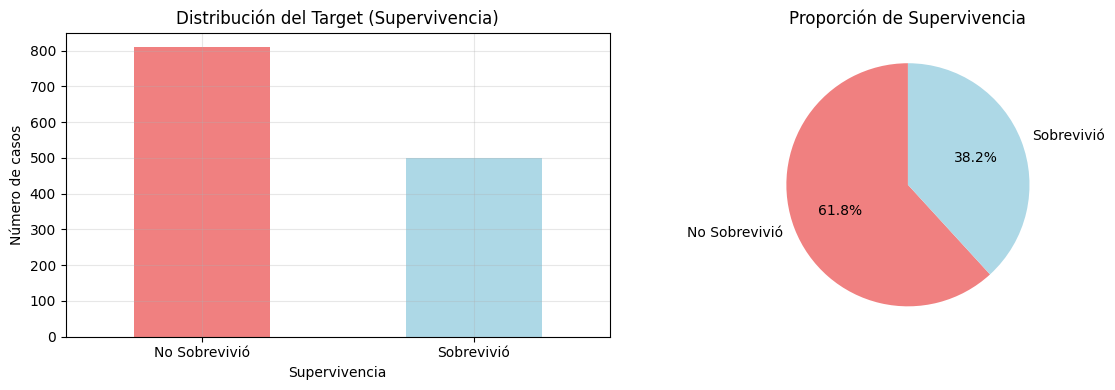

In [ ]:
# Limpiar datos
print("\nLimpiando datos...")

# Rellenar valores faltantes primero
df_clean['age'].fillna(df_clean['age'].median(), inplace=True)
df_clean['embarked'].fillna('S', inplace=True)  # Valor más común
df_clean['fare'].fillna(df_clean['fare'].median(), inplace=True)

print("Valores faltantes después de rellenar:")
print(df_clean.isnull().sum())

# Convertir variables categóricas a numéricas
print("\nConvirtiendo variables categóricas a numéricas...")

# Convertir sex
if df_clean['sex'].dtype == 'category' or df_clean['sex'].dtype == 'object':
    df_clean['sex'] = df_clean['sex'].map({'male': 0, 'female': 1})
    if df_clean['sex'].isnull().any():
        # Si hay valores no mapeados, usar códigos categóricos
        df_clean['sex'] = pd.Categorical(df_clean['sex']).codes

# Convertir embarked
if df_clean['embarked'].dtype == 'category' or df_clean['embarked'].dtype == 'object':
    df_clean['embarked'] = df_clean['embarked'].map({'C': 0, 'Q': 1, 'S': 2})
    if df_clean['embarked'].isnull().any():
        # Si hay valores no mapeados, usar códigos categóricos
        df_clean['embarked'] = pd.Categorical(df_clean['embarked']).codes

# Asegurar que todas las columnas sean numéricas
for col in df_clean.columns:
    if df_clean[col].dtype == 'category':
        print(f"Convirtiendo {col} de category a numeric...")
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    elif df_clean[col].dtype == 'object':
        print(f"Convirtiendo {col} de object a numeric...")
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Rellenar cualquier NaN que pueda haber resultado de la conversión
df_clean.fillna(0, inplace=True)

print("\nTipos de datos finales:")
print(df_clean.dtypes)
print("\nValores faltantes finales:")
print(df_clean.isnull().sum())

# Separar características y target
X = df_clean.drop('survived', axis=1)
y = df_clean['survived']

# Convertir y a numérico si es categórico
if y.dtype == 'category' or y.dtype == 'object':
    print("Convirtiendo target categórico a numérico...")
    # Mapear valores categóricos a numéricos
    if y.dtype == 'category':
        y = y.cat.codes
    else:
        # Si es string, mapear manualmente
        y = y.map({'0': 0, '1': 1, 0: 0, 1: 1}).astype(int)

print(f"\nCaracterísticas finales: {list(X.columns)}")
print(f"Target: {y.name} (tipo: {y.dtype})")
print(f"Distribución del target:")
print(y.value_counts())
print(f"Proporción de supervivientes: {y.mean():.3f}")

# Visualización de la distribución del target
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
y.value_counts().plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Distribución del Target (Supervivencia)')
plt.xlabel('Supervivencia')
plt.ylabel('Número de casos')
plt.xticks([0, 1], ['No Sobrevivió', 'Sobrevivió'], rotation=0)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
colors = ['lightcoral', 'lightblue']
plt.pie(y.value_counts(), labels=['No Sobrevivió', 'Sobrevivió'],
        autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Proporción de Supervivencia')

plt.tight_layout()
plt.show()

### Preparamos Train y Test

Vemos muestras

In [ ]:
# Dividir datos en train/test
print("\nDividiendo datos en train/test (80/20)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} muestras")
print(f"Test set: {X_test.shape[0]} muestras")
print(f"Distribución train: {y_train.value_counts().values}")
print(f"Distribución test: {y_test.value_counts().values}")


Dividiendo datos en train/test (80/20)...
Training set: 1047 muestras
Test set: 262 muestras
Distribución train: [647 400]
Distribución test: [162 100]


### Busqueda de Hiperparametros

Tenemos 3 bloques, Grid Search, Random Search y Optimización Bayesiana

In [ ]:
# -----------------------------------------------------------------------------
# 2.1 GRID SEARCH
# -----------------------------------------------------------------------------
print("\n" + "-"*30)
print("2.1 GRID SEARCH")
print("-"*30)

print("Grid Search realiza una búsqueda exhaustiva en todos los parámetros especificados")

# Random Forest con Grid Search
rf_grid = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}

print("Parámetros a evaluar en Grid Search:")
for param, values in param_grid_rf.items():
    print(f"  {param}: {values}")

total_combinations = 1
for values in param_grid_rf.values():
    total_combinations *= len(values)
print(f"Total de combinaciones a evaluar: {total_combinations}")

print("\nEjecutando Grid Search...")
grid_search = GridSearchCV(
    rf_grid, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)

print(f"Mejores parámetros encontrados: {grid_search.best_params_}")
print(f"Mejor score de validación cruzada: {grid_search.best_score_:.4f}")

# Evaluar en test
y_pred_grid = grid_search.predict(X_test)
accuracy_grid = accuracy_score(y_test, y_pred_grid)
print(f"Accuracy en conjunto de test: {accuracy_grid:.4f}")

best_rf_grid = grid_search.best_estimator_


------------------------------
2.1 GRID SEARCH
------------------------------
Grid Search realiza una búsqueda exhaustiva en todos los parámetros especificados
Parámetros a evaluar en Grid Search:
  n_estimators: [50, 100, 200]
  max_depth: [3, 5, 10, None]
  min_samples_split: [2, 5, 10]
Total de combinaciones a evaluar: 36

Ejecutando Grid Search...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores parámetros encontrados: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}
Mejor score de validación cruzada: 0.8013
Accuracy en conjunto de test: 0.8092


In [ ]:
# -----------------------------------------------------------------------------
# 2.2 RANDOM SEARCH
# -----------------------------------------------------------------------------
print("\n" + "-"*30)
print("2.2 RANDOM SEARCH")
print("-"*30)

print("Random Search evalúa combinaciones aleatorias de parámetros")
print("Es más eficiente cuando hay muchos hiperparámetros")

if xgboost_available:
    # XGBoost con Random Search
    xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

    param_dist_xgb = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }

    print("Distribución de parámetros para Random Search:")
    for param, values in param_dist_xgb.items():
        print(f"  {param}: {values}")

    n_iter = 20
    print(f"Número de iteraciones aleatorias: {n_iter}")

    print("Ejecutando Random Search...")
    random_search = RandomizedSearchCV(
        xgb_model, param_dist_xgb, n_iter=n_iter, cv=5,
        scoring='accuracy', random_state=42, n_jobs=-1, verbose=1
    )
    random_search.fit(X_train, y_train)

    print(f"Mejores parámetros: {random_search.best_params_}")
    print(f"Mejor score CV: {random_search.best_score_:.4f}")

    # Evaluar en test
    y_pred_random = random_search.predict(X_test)
    accuracy_random = accuracy_score(y_test, y_pred_random)
    print(f"Accuracy en test: {accuracy_random:.4f}")

    best_xgb_random = random_search.best_estimator_
else:
    print("XGBoost no disponible, usando Random Forest para Random Search")
    # Usar Random Forest con más parámetros
    rf_random = RandomForestClassifier(random_state=42)

    param_dist_rf = {
        'n_estimators': [50, 100, 150, 200, 300],
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 4, 8],
        'max_features': ['sqrt', 'log2', None]
    }

    random_search = RandomizedSearchCV(
        rf_random, param_dist_rf, n_iter=20, cv=5,
        scoring='accuracy', random_state=42, n_jobs=-1
    )
    random_search.fit(X_train, y_train)

    print(f"Mejores parámetros: {random_search.best_params_}")
    print(f"Mejor score CV: {random_search.best_score_:.4f}")

    y_pred_random = random_search.predict(X_test)
    accuracy_random = accuracy_score(y_test, y_pred_random)
    print(f"Accuracy en test: {accuracy_random:.4f}")



------------------------------
2.2 RANDOM SEARCH
------------------------------
Random Search evalúa combinaciones aleatorias de parámetros
Es más eficiente cuando hay muchos hiperparámetros
Distribución de parámetros para Random Search:
  n_estimators: [50, 100, 200, 300]
  max_depth: [3, 4, 5, 6, 7]
  learning_rate: [0.01, 0.1, 0.2, 0.3]
  subsample: [0.8, 0.9, 1.0]
  colsample_bytree: [0.8, 0.9, 1.0]
Número de iteraciones aleatorias: 20
Ejecutando Random Search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores parámetros: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Mejor score CV: 0.8023
Accuracy en test: 0.8168



------------------------------
2.3 OPTIMIZACIÓN BAYESIANA
------------------------------
Optimización Bayesiana usa un modelo probabilístico para guiar la búsqueda
Es más inteligente que Random Search
Espacios de búsqueda bayesiana:
  n_estimators: Integer(low=50, high=300, prior='uniform', transform='identity')
  max_depth: Integer(low=3, high=10, prior='uniform', transform='identity')
  learning_rate: Real(low=0.01, high=0.3, prior='log-uniform', transform='identity')
  subsample: Real(low=0.7, high=1.0, prior='uniform', transform='identity')
  colsample_bytree: Real(low=0.7, high=1.0, prior='uniform', transform='identity')
  num_leaves: Integer(low=10, high=100, prior='uniform', transform='identity')
Número de evaluaciones: 20
Ejecutando Optimización Bayesiana...
Mejores parámetros: OrderedDict({'colsample_bytree': 1.0, 'learning_rate': 0.01181879377668257, 'max_depth': 8, 'n_estimators': 300, 'num_leaves': 100, 'subsample': 0.9607146226445974})
Mejor score CV: 0.7994
Accuracy en t

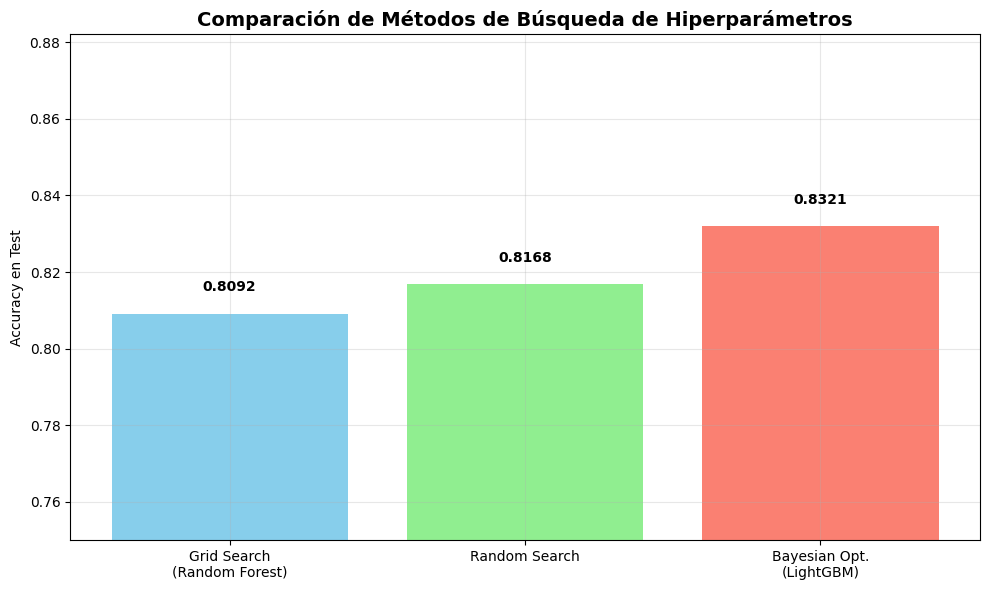

In [ ]:
# -----------------------------------------------------------------------------
# 2.3 OPTIMIZACIÓN BAYESIANA
# -----------------------------------------------------------------------------
print("\n" + "-"*30)
print("2.3 OPTIMIZACIÓN BAYESIANA")
print("-"*30)

if bayesian_available and lightgbm_available:
    print("Optimización Bayesiana usa un modelo probabilístico para guiar la búsqueda")
    print("Es más inteligente que Random Search")

    # LightGBM con Optimización Bayesiana
    lgb_model = lgb.LGBMClassifier(random_state=42, verbose=-1)

    search_spaces = {
        'n_estimators': Integer(50, 300),
        'max_depth': Integer(3, 10),
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'subsample': Real(0.7, 1.0),
        'colsample_bytree': Real(0.7, 1.0),
        'num_leaves': Integer(10, 100)
    }

    print("Espacios de búsqueda bayesiana:")
    for param, space in search_spaces.items():
        print(f"  {param}: {space}")

    n_calls = 20
    print(f"Número de evaluaciones: {n_calls}")

    print("Ejecutando Optimización Bayesiana...")
    bayes_search = BayesSearchCV(
        lgb_model, search_spaces, n_iter=n_calls, cv=5,
        scoring='accuracy', random_state=42, n_jobs=-1
    )
    bayes_search.fit(X_train, y_train)

    print(f"Mejores parámetros: {bayes_search.best_params_}")
    print(f"Mejor score CV: {bayes_search.best_score_:.4f}")

    # Evaluar en test
    y_pred_bayes = bayes_search.predict(X_test)
    accuracy_bayes = accuracy_score(y_test, y_pred_bayes)
    print(f"Accuracy en test: {accuracy_bayes:.4f}")

    best_lgb_bayes = bayes_search.best_estimator_
else:
    print("Optimización Bayesiana no disponible.")
    print("Instala con: pip install scikit-optimize lightgbm")

# Comparar resultados de búsqueda
print("\n" + "-"*40)
print("COMPARACIÓN DE MÉTODOS DE BÚSQUEDA")
print("-"*40)
print(f"Grid Search (Random Forest):     {accuracy_grid:.4f}")
print(f"Random Search:                   {accuracy_random:.4f}")
if bayesian_available and lightgbm_available:
    print(f"Optimización Bayesiana (LightGBM): {accuracy_bayes:.4f}")

# Visualización comparativa de métodos de búsqueda
search_methods = ['Grid Search\n(Random Forest)', 'Random Search']
search_scores = [accuracy_grid, accuracy_random]

if bayesian_available and lightgbm_available:
    search_methods.append('Bayesian Opt.\n(LightGBM)')
    search_scores.append(accuracy_bayes)

plt.figure(figsize=(10, 6))
bars = plt.bar(search_methods, search_scores, color=['skyblue', 'lightgreen', 'salmon'][:len(search_methods)])
plt.title('Comparación de Métodos de Búsqueda de Hiperparámetros', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy en Test')
plt.ylim(0.75, max(search_scores) + 0.05)

# Añadir valores en las barras
for bar, score in zip(bars, search_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Regularización y Early Stopping

Tenemos 3 bloques, Regularización L1 (Lasso), Regularización L2 (Ridge) y Early Stopping

In [ ]:
# Escalar datos para regularización
print("Escalando datos para técnicas de regularización...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Escalando datos para técnicas de regularización...



------------------------------
3.1 REGULARIZACIÓN L1 (LASSO)
------------------------------
L1 (Lasso) penaliza la suma de valores absolutos de los coeficientes
Tiende a hacer que algunos coeficientes sean exactamente 0 (selección de características)
Probando valores de C (inverso de regularización): [0.01, 0.1, 1, 10, 100]
C más bajo = más regularización

Resultados L1 (Lasso):
C        | Train Acc | Test Acc  | Features Seleccionadas
-------------------------------------------------------
    0.01 |    0.7746 |    0.8015 |                  2
    0.10 |    0.7832 |    0.8168 |                  6
    1.00 |    0.7861 |    0.8206 |                  7
   10.00 |    0.7822 |    0.8206 |                  7
  100.00 |    0.7822 |    0.8206 |                  7

Mejor C para L1: 1 con accuracy test: 0.8206


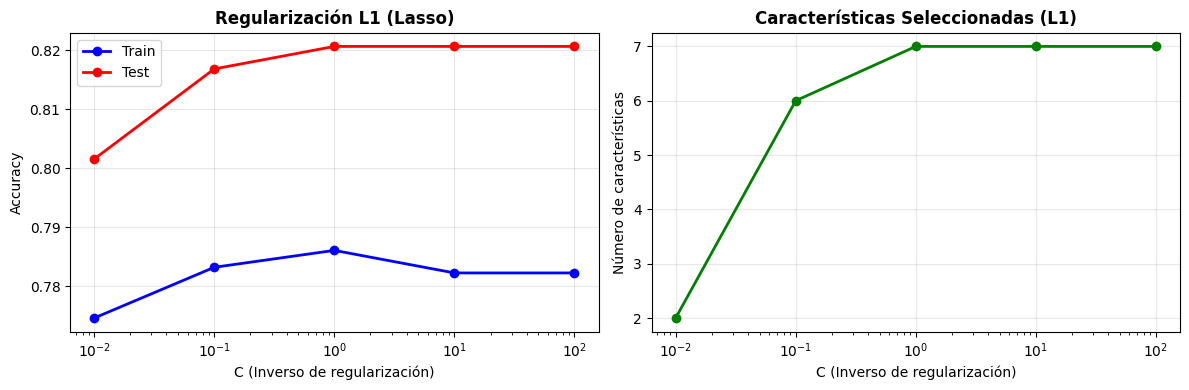

In [ ]:
# -----------------------------------------------------------------------------
# 3.1 REGULARIZACIÓN L1 (LASSO)
# -----------------------------------------------------------------------------
print("\n" + "-"*30)
print("3.1 REGULARIZACIÓN L1 (LASSO)")
print("-"*30)

print("L1 (Lasso) penaliza la suma de valores absolutos de los coeficientes")
print("Tiende a hacer que algunos coeficientes sean exactamente 0 (selección de características)")

C_values = [0.01, 0.1, 1, 10, 100]
print(f"Probando valores de C (inverso de regularización): {C_values}")
print("C más bajo = más regularización")

print("\nResultados L1 (Lasso):")
print("C        | Train Acc | Test Acc  | Features Seleccionadas")
print("-" * 55)

lasso_results = []
for C in C_values:
    model_l1 = LogisticRegression(penalty='l1', C=C, solver='liblinear', random_state=42, max_iter=1000)
    model_l1.fit(X_train_scaled, y_train)

    train_score = model_l1.score(X_train_scaled, y_train)
    test_score = model_l1.score(X_test_scaled, y_test)
    n_features_selected = np.sum(model_l1.coef_[0] != 0)

    lasso_results.append({
        'C': C, 'train_score': train_score, 'test_score': test_score,
        'n_features': n_features_selected
    })

    print(f"{C:8.2f} | {train_score:9.4f} | {test_score:9.4f} | {n_features_selected:18d}")

# Mejor modelo L1
best_l1 = max(lasso_results, key=lambda x: x['test_score'])
print(f"\nMejor C para L1: {best_l1['C']} con accuracy test: {best_l1['test_score']:.4f}")

# Visualización de regularización L1
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
C_vals = [r['C'] for r in lasso_results]
train_scores_l1 = [r['train_score'] for r in lasso_results]
test_scores_l1 = [r['test_score'] for r in lasso_results]

plt.semilogx(C_vals, train_scores_l1, 'o-', label='Train', color='blue', linewidth=2)
plt.semilogx(C_vals, test_scores_l1, 'o-', label='Test', color='red', linewidth=2)
plt.title('Regularización L1 (Lasso)', fontweight='bold')
plt.xlabel('C (Inverso de regularización)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
n_features = [r['n_features'] for r in lasso_results]
plt.semilogx(C_vals, n_features, 'o-', color='green', linewidth=2)
plt.title('Características Seleccionadas (L1)', fontweight='bold')
plt.xlabel('C (Inverso de regularización)')
plt.ylabel('Número de características')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



------------------------------
3.2 REGULARIZACIÓN L2 (RIDGE)
------------------------------
L2 (Ridge) penaliza la suma de cuadrados de los coeficientes
Tiende a reducir los coeficientes pero no los hace exactamente 0

Resultados L2 (Ridge):
C        | Train Acc | Test Acc  | Norma L2 Coeficientes
-------------------------------------------------------
    0.01 |    0.7880 |    0.8359 |            0.8896
    0.10 |    0.7841 |    0.8168 |            1.4094
    1.00 |    0.7841 |    0.8206 |            1.5397
   10.00 |    0.7822 |    0.8206 |            1.5553
  100.00 |    0.7822 |    0.8206 |            1.5569

Mejor C para L2: 0.01 con accuracy test: 0.8359


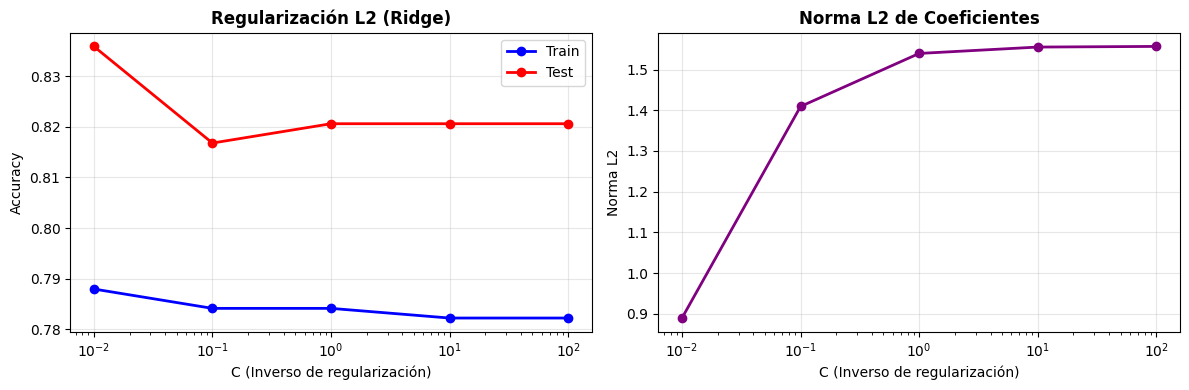

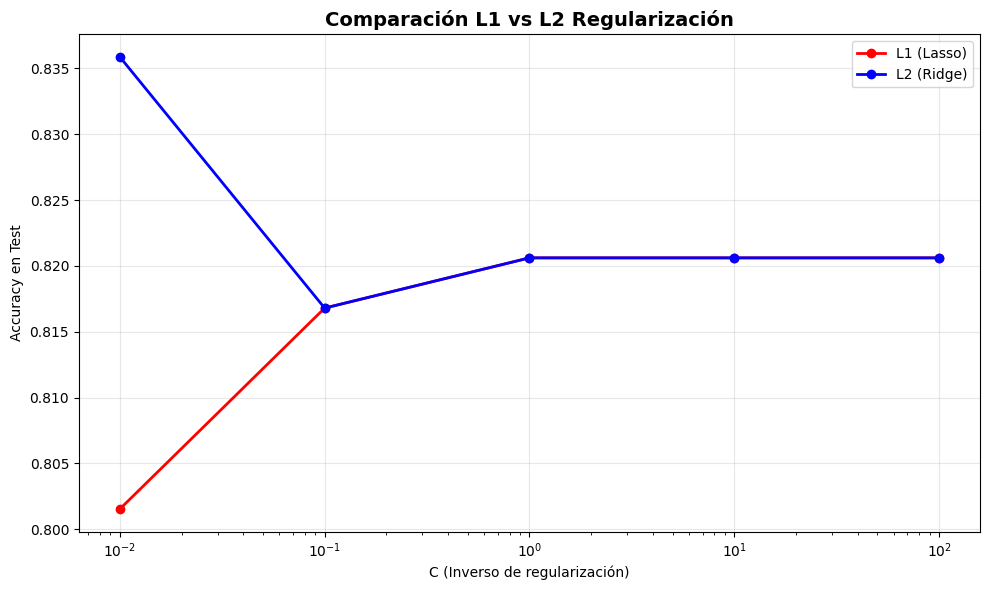

In [ ]:
# -----------------------------------------------------------------------------
# 3.2 REGULARIZACIÓN L2 (RIDGE)
# -----------------------------------------------------------------------------
print("\n" + "-"*30)
print("3.2 REGULARIZACIÓN L2 (RIDGE)")
print("-"*30)

print("L2 (Ridge) penaliza la suma de cuadrados de los coeficientes")
print("Tiende a reducir los coeficientes pero no los hace exactamente 0")

print("\nResultados L2 (Ridge):")
print("C        | Train Acc | Test Acc  | Norma L2 Coeficientes")
print("-" * 55)

ridge_results = []
for C in C_values:
    model_l2 = LogisticRegression(penalty='l2', C=C, random_state=42, max_iter=1000)
    model_l2.fit(X_train_scaled, y_train)

    train_score = model_l2.score(X_train_scaled, y_train)
    test_score = model_l2.score(X_test_scaled, y_test)
    l2_norm = np.linalg.norm(model_l2.coef_)

    ridge_results.append({
        'C': C, 'train_score': train_score, 'test_score': test_score,
        'l2_norm': l2_norm
    })

    print(f"{C:8.2f} | {train_score:9.4f} | {test_score:9.4f} | {l2_norm:17.4f}")

# Mejor modelo L2
best_l2 = max(ridge_results, key=lambda x: x['test_score'])
print(f"\nMejor C para L2: {best_l2['C']} con accuracy test: {best_l2['test_score']:.4f}")

# Visualización de regularización L2
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
C_vals = [r['C'] for r in ridge_results]
train_scores_l2 = [r['train_score'] for r in ridge_results]
test_scores_l2 = [r['test_score'] for r in ridge_results]

plt.semilogx(C_vals, train_scores_l2, 'o-', label='Train', color='blue', linewidth=2)
plt.semilogx(C_vals, test_scores_l2, 'o-', label='Test', color='red', linewidth=2)
plt.title('Regularización L2 (Ridge)', fontweight='bold')
plt.xlabel('C (Inverso de regularización)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
l2_norms = [r['l2_norm'] for r in ridge_results]
plt.semilogx(C_vals, l2_norms, 'o-', color='purple', linewidth=2)
plt.title('Norma L2 de Coeficientes', fontweight='bold')
plt.xlabel('C (Inverso de regularización)')
plt.ylabel('Norma L2')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Comparación L1 vs L2
plt.figure(figsize=(10, 6))
plt.semilogx(C_vals, test_scores_l1, 'o-', label='L1 (Lasso)', color='red', linewidth=2)
plt.semilogx(C_vals, test_scores_l2, 'o-', label='L2 (Ridge)', color='blue', linewidth=2)
plt.title('Comparación L1 vs L2 Regularización', fontsize=14, fontweight='bold')
plt.xlabel('C (Inverso de regularización)')
plt.ylabel('Accuracy en Test')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------------------------------------------------------
# 3.3 EARLY STOPPING
# -----------------------------------------------------------------------------
print("\n" + "-"*30)
print("3.3 EARLY STOPPING")
print("-"*30)

print("Early Stopping detiene el entrenamiento cuando la mejora se estanca")
print("Evita overfitting en modelos iterativos")

if xgboost_available:
    # Dividir training en train y validation para early stopping
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    print(f"Dividiendo training en: {X_tr.shape[0]} train, {X_val.shape[0]} validación")

    # XGBoost con early stopping
    print("\nEntrenando XGBoost con early stopping...")
    model_es = xgb.XGBClassifier(
        n_estimators=1000,  # Número alto
        learning_rate=0.1,
        random_state=42,
        early_stopping_rounds=10,  # Parar si no mejora en 10 rondas
        eval_metric='logloss'
    )

    model_es.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    print(f"Número óptimo de estimadores (early stopping): {model_es.best_iteration}")
    print(f"Mejor score de validación: {model_es.best_score:.4f}")

    # Evaluar en test
    test_score_es = model_es.score(X_test, y_test)
    print(f"Accuracy en test con early stopping: {test_score_es:.4f}")

    # Comparar con modelo sin early stopping
    print("\nComparando con modelo sin early stopping...")
    model_no_es = xgb.XGBClassifier(
        n_estimators=1000,  # Mismo número alto
        learning_rate=0.1,
        random_state=42,
        eval_metric='logloss'
    )
    model_no_es.fit(X_tr, y_tr)
    test_score_no_es = model_no_es.score(X_test, y_test)

    print(f"Sin early stopping - Accuracy test: {test_score_no_es:.4f}")
    print(f"Diferencia (ES - No ES): {test_score_es - test_score_no_es:.4f}")

    if test_score_es > test_score_no_es:
        print("✅ Early stopping mejoró el rendimiento")
    else:
        print("⚠️ Early stopping no mejoró el rendimiento en este caso")
else:
    print("XGBoost no disponible para demostrar Early Stopping")
    print("Se puede usar con GradientBoostingClassifier también")


------------------------------
3.3 EARLY STOPPING
------------------------------
Early Stopping detiene el entrenamiento cuando la mejora se estanca
Evita overfitting en modelos iterativos
Dividiendo training en: 837 train, 210 validación

Entrenando XGBoost con early stopping...
Número óptimo de estimadores (early stopping): 24
Mejor score de validación: 0.4531
Accuracy en test con early stopping: 0.8130

Comparando con modelo sin early stopping...
Sin early stopping - Accuracy test: 0.7901
Diferencia (ES - No ES): 0.0229
✅ Early stopping mejoró el rendimiento


### Validación y Deteccion de Overfitting

Tenemos 3 bloques, Validación cruzada estandar y Validación cruzada estratificada


------------------------------
4.1 VALIDACIÓN CRUZADA ESTÁNDAR
------------------------------
Validación cruzada divide los datos en k partes y entrena k veces
Cada vez usa k-1 partes para entrenar y 1 para validar
Comparando 5 modelos con validación cruzada de 5 folds...

Resultados de Validación Cruzada:
Modelo               | Media    | Std     | Min     | Max
------------------------------------------------------------
Decision Tree        | 0.6562 | 0.0870 | 0.4962 | 0.7595
Random Forest        | 0.6493 | 0.0781 | 0.5038 | 0.7328
Gradient Boosting    | 0.6860 | 0.1052 | 0.5153 | 0.8397
XGBoost              | 0.6631 | 0.0853 | 0.5076 | 0.7634
LightGBM             | 0.6639 | 0.0844 | 0.5115 | 0.7634

Mejor modelo por CV: Gradient Boosting (0.6860 ± 0.1052)


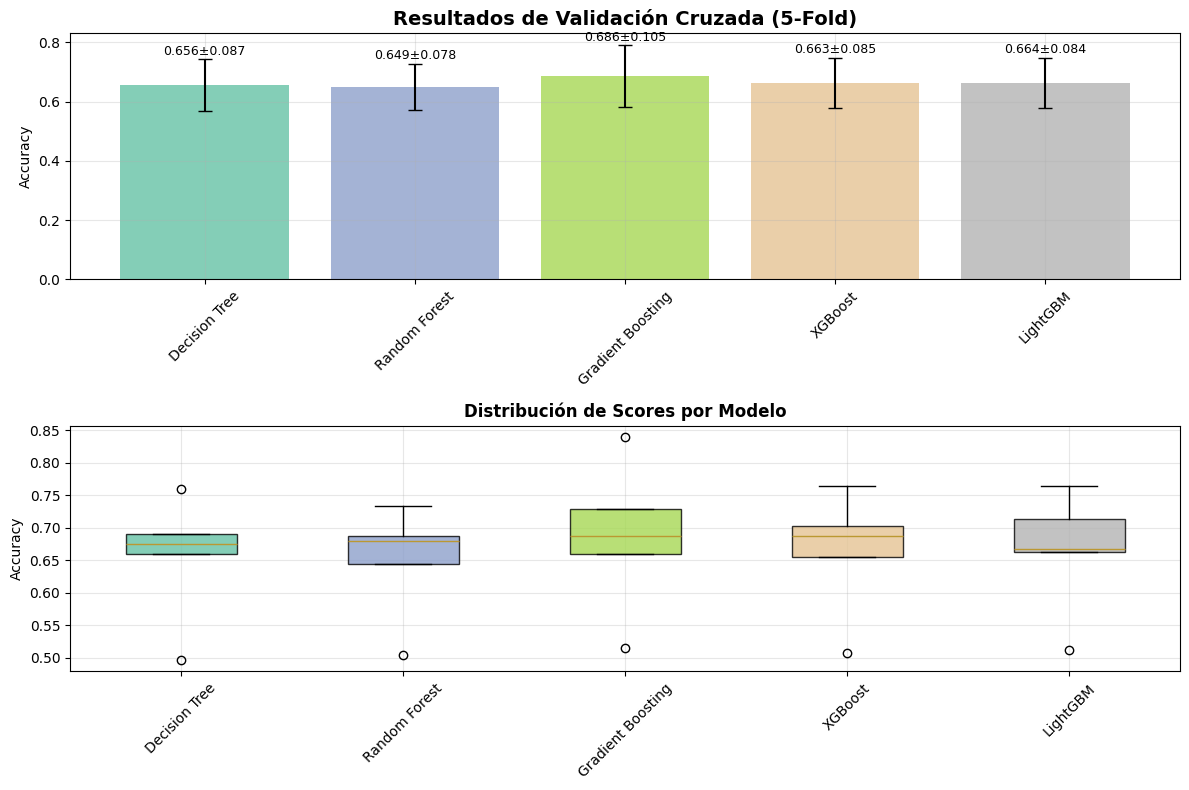

In [ ]:
# -----------------------------------------------------------------------------
# 4.1 VALIDACIÓN CRUZADA ESTÁNDAR
# -----------------------------------------------------------------------------
print("\n" + "-"*30)
print("4.1 VALIDACIÓN CRUZADA ESTÁNDAR")
print("-"*30)

print("Validación cruzada divide los datos en k partes y entrena k veces")
print("Cada vez usa k-1 partes para entrenar y 1 para validar")

# Definir modelos a comparar
modelos = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

if xgboost_available:
    modelos['XGBoost'] = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

if lightgbm_available:
    modelos['LightGBM'] = lgb.LGBMClassifier(random_state=42, verbose=-1)

print(f"Comparando {len(modelos)} modelos con validación cruzada de 5 folds...")

print("\nResultados de Validación Cruzada:")
print("Modelo               | Media    | Std     | Min     | Max")
print("-" * 60)

cv_results = {}
for name, model in modelos.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_results[name] = {
        'mean': scores.mean(),
        'std': scores.std(),
        'min': scores.min(),
        'max': scores.max(),
        'scores': scores
    }

    print(f"{name:20s} | {scores.mean():.4f} | {scores.std():.4f} | {scores.min():.4f} | {scores.max():.4f}")

# Mejor modelo
best_model = max(cv_results.keys(), key=lambda x: cv_results[x]['mean'])
print(f"\nMejor modelo por CV: {best_model} ({cv_results[best_model]['mean']:.4f} ± {cv_results[best_model]['std']:.4f})")

# Visualización de resultados de validación cruzada
plt.figure(figsize=(12, 8))

# Gráfico de barras con barras de error
model_names = list(cv_results.keys())
means = [cv_results[name]['mean'] for name in model_names]
stds = [cv_results[name]['std'] for name in model_names]

colors = plt.cm.Set2(np.linspace(0, 1, len(model_names)))

plt.subplot(2, 1, 1)
bars = plt.bar(model_names, means, yerr=stds, capsize=5, color=colors, alpha=0.8)
plt.title('Resultados de Validación Cruzada (5-Fold)', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Añadir valores en las barras
for bar, mean, std in zip(bars, means, stds):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.005,
             f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=9)

# Box plot de los scores
plt.subplot(2, 1, 2)
scores_data = [cv_results[name]['scores'] for name in model_names]
box_plot = plt.boxplot(scores_data, labels=model_names, patch_artist=True)

# Colorear las cajas
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)

plt.title('Distribución de Scores por Modelo', fontweight='bold')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


------------------------------
4.2 VALIDACIÓN CRUZADA ESTRATIFICADA
------------------------------
Stratified CV mantiene la proporción de clases en cada fold
Importante para datasets desbalanceados
Distribución original del target:
  Clase 0: 0.618
  Clase 1: 0.382

Usando StratifiedKFold con 5 splits...
Verificando proporciones por fold:
Fold | Clase 0 | Clase 1
-------------------------
   1 |   0.618 |   0.382
   2 |   0.618 |   0.382
   3 |   0.618 |   0.382
   4 |   0.618 |   0.382
   5 |   0.617 |   0.383
Desviación estándar entre folds:
  Clase 0: 0.0006
  Clase 1: 0.0006

Random Forest con Stratified CV:
Scores por fold: [0.75954198 0.80534351 0.77862595 0.82442748 0.77777778]
Media: 0.7891 (+/- 0.0458)


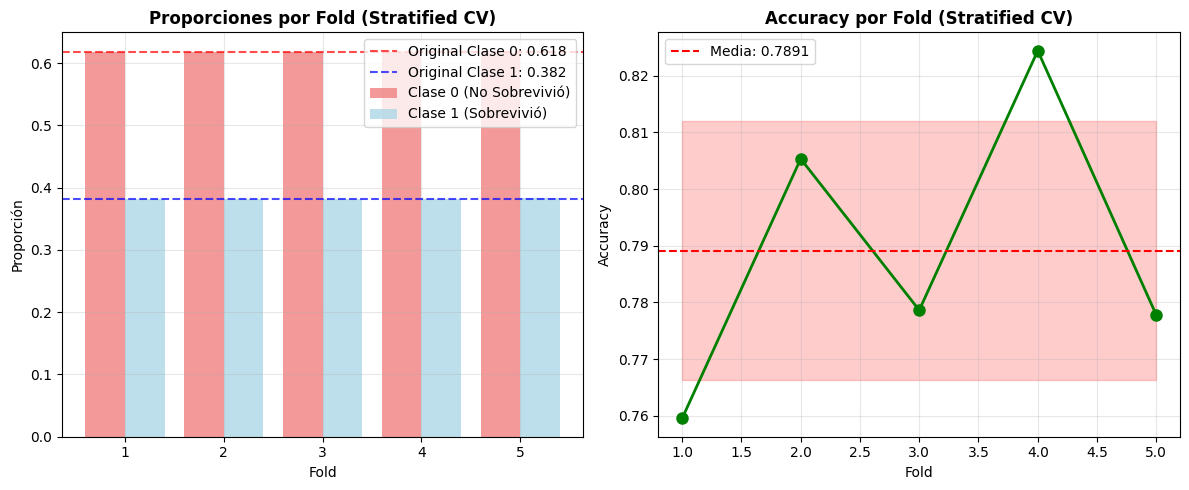

In [ ]:
# -----------------------------------------------------------------------------
# 4.2 VALIDACIÓN CRUZADA ESTRATIFICADA
# -----------------------------------------------------------------------------
print("\n" + "-"*30)
print("4.2 VALIDACIÓN CRUZADA ESTRATIFICADA")
print("-"*30)

print("Stratified CV mantiene la proporción de clases en cada fold")
print("Importante para datasets desbalanceados")

print("Distribución original del target:")
target_dist = y.value_counts(normalize=True)
for class_val, prop in target_dist.items():
    print(f"  Clase {class_val}: {prop:.3f}")

# Usar StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"\nUsando StratifiedKFold con {skf.n_splits} splits...")

# Verificar que cada fold mantiene la proporción
print("Verificando proporciones por fold:")
print("Fold | Clase 0 | Clase 1")
print("-" * 25)

fold_proportions = []
for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    fold_y = y.iloc[test_idx]
    prop_0 = (fold_y == 0).mean()
    prop_1 = (fold_y == 1).mean()
    fold_proportions.append([prop_0, prop_1])
    print(f"{i+1:4d} | {prop_0:7.3f} | {prop_1:7.3f}")

print(f"Desviación estándar entre folds:")
fold_props_array = np.array(fold_proportions)
print(f"  Clase 0: {fold_props_array[:, 0].std():.4f}")
print(f"  Clase 1: {fold_props_array[:, 1].std():.4f}")

# Aplicar a Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
stratified_scores = cross_val_score(rf_model, X, y, cv=skf, scoring='accuracy')

print(f"\nRandom Forest con Stratified CV:")
print(f"Scores por fold: {stratified_scores}")
print(f"Media: {stratified_scores.mean():.4f} (+/- {stratified_scores.std() * 2:.4f})")

# Visualización de Stratified CV
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Proporciones por fold
fold_props_array = np.array(fold_proportions)
folds = range(1, len(fold_proportions) + 1)

plt.bar([f - 0.2 for f in folds], fold_props_array[:, 0], 0.4,
        label='Clase 0 (No Sobrevivió)', color='lightcoral', alpha=0.8)
plt.bar([f + 0.2 for f in folds], fold_props_array[:, 1], 0.4,
        label='Clase 1 (Sobrevivió)', color='lightblue', alpha=0.8)

plt.axhline(y=target_dist[0], color='red', linestyle='--', alpha=0.7,
           label=f'Original Clase 0: {target_dist[0]:.3f}')
plt.axhline(y=target_dist[1], color='blue', linestyle='--', alpha=0.7,
           label=f'Original Clase 1: {target_dist[1]:.3f}')

plt.title('Proporciones por Fold (Stratified CV)', fontweight='bold')
plt.xlabel('Fold')
plt.ylabel('Proporción')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Scores por fold
plt.plot(folds, stratified_scores, 'o-', color='green', linewidth=2, markersize=8)
plt.axhline(y=stratified_scores.mean(), color='red', linestyle='--',
           label=f'Media: {stratified_scores.mean():.4f}')
plt.fill_between(folds,
                stratified_scores.mean() - stratified_scores.std(),
                stratified_scores.mean() + stratified_scores.std(),
                alpha=0.2, color='red')

plt.title('Accuracy por Fold (Stratified CV)', fontweight='bold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


------------------------------
4.3 DETECCIÓN DE OVERFITTING
------------------------------
Overfitting ocurre cuando el modelo memoriza los datos de entrenamiento
Se detecta comparando performance en train vs validación

Análisis de Overfitting usando Learning Curves:
Modelo                     | Train Final | Val Final | Gap     | Overfitting
--------------------------------------------------------------------------------
Decision Tree (Profundo)   |      0.9694 |    0.6562 |  0.3132 | ⚠️  SÍ
Decision Tree (Limitado)   |      0.8395 |    0.6799 |  0.1597 | ⚠️  SÍ
Random Forest (200 árboles) |      0.9694 |    0.6486 |  0.3209 | ⚠️  SÍ
Random Forest (20 árboles) |      0.9635 |    0.6478 |  0.3157 | ⚠️  SÍ


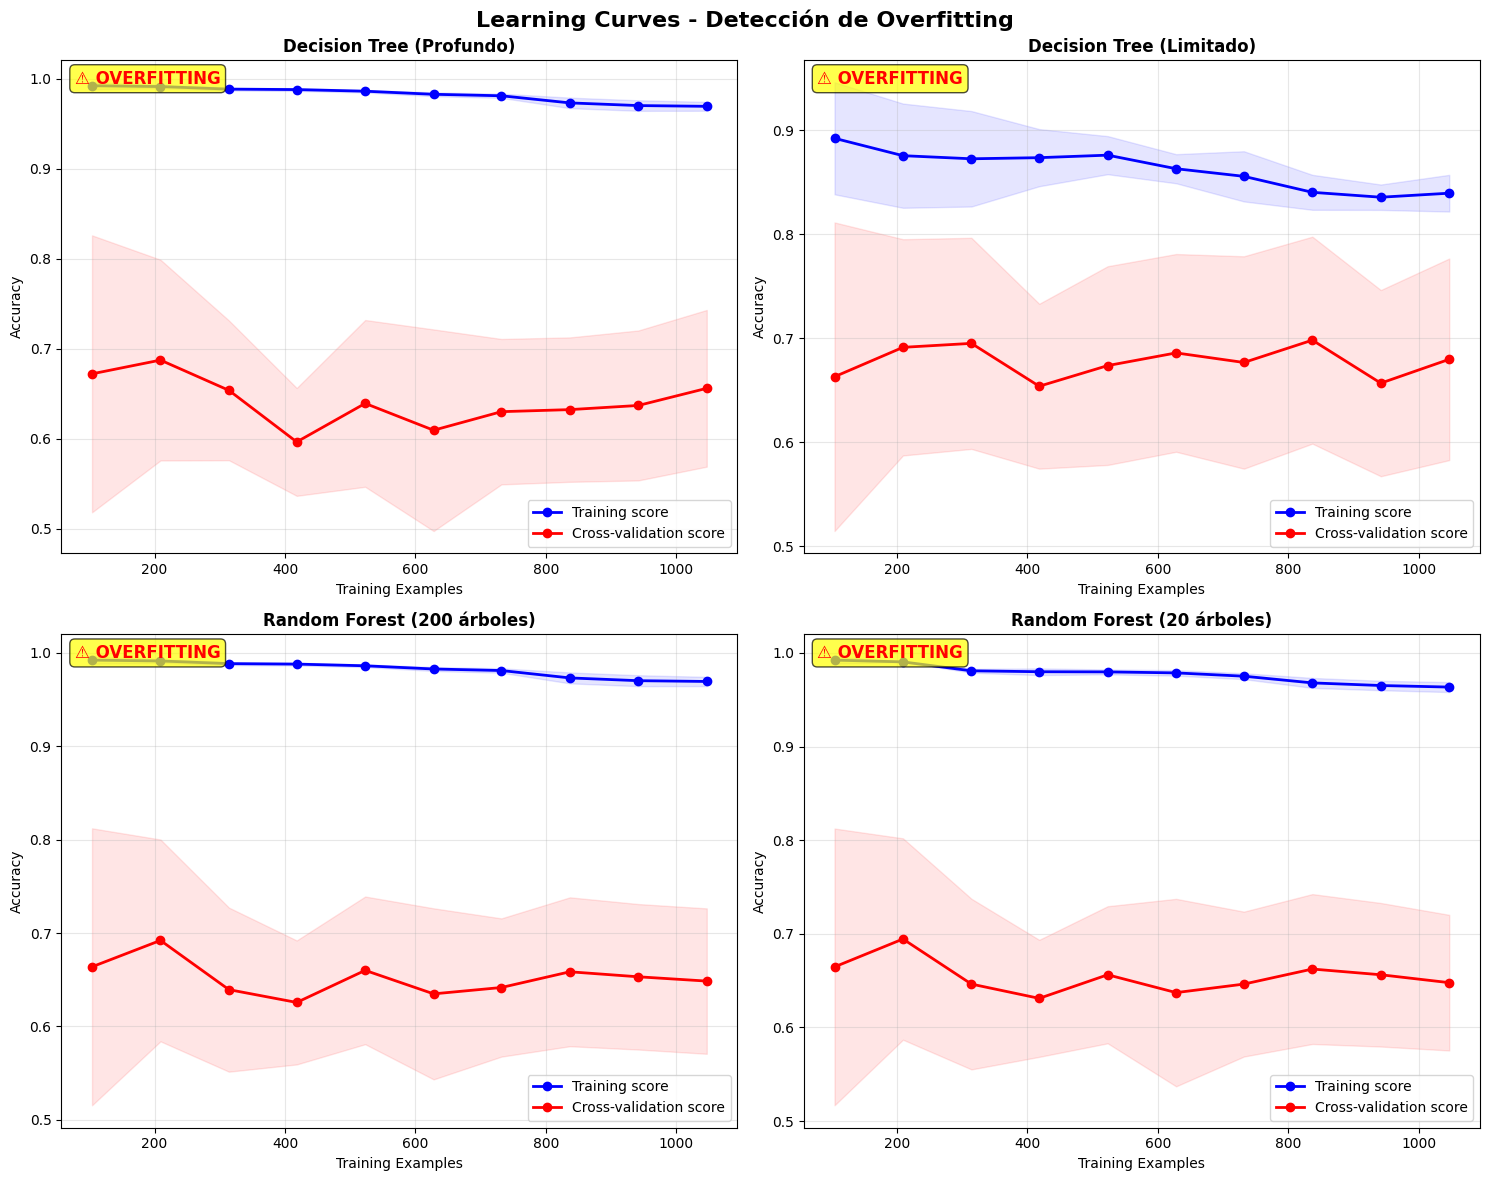

In [ ]:
# -----------------------------------------------------------------------------
# 4.3 DETECCIÓN DE OVERFITTING
# -----------------------------------------------------------------------------
print("\n" + "-"*30)
print("4.3 DETECCIÓN DE OVERFITTING")
print("-"*30)

print("Overfitting ocurre cuando el modelo memoriza los datos de entrenamiento")
print("Se detecta comparando performance en train vs validación")

# Comparar modelos con diferentes complejidades
modelos_complexity = {
    'Decision Tree (Profundo)': DecisionTreeClassifier(max_depth=None, random_state=42),
    'Decision Tree (Limitado)': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest (200 árboles)': RandomForestClassifier(n_estimators=200, random_state=42),
    'Random Forest (20 árboles)': RandomForestClassifier(n_estimators=20, random_state=42)
}

print("\nAnálisis de Overfitting usando Learning Curves:")
print("Modelo                     | Train Final | Val Final | Gap     | Overfitting")
print("-" * 80)

learning_curve_data = {}

for name, model in modelos_complexity.items():
    # Curva de aprendizaje
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy', random_state=42
    )

    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)

    # Guardar datos para visualización
    learning_curve_data[name] = {
        'train_sizes': train_sizes,
        'train_mean': train_mean,
        'train_std': train_std,
        'val_mean': val_mean,
        'val_std': val_std
    }

    # Analizar overfitting en el punto final
    final_train = train_mean[-1]
    final_val = val_mean[-1]
    gap = final_train - final_val

    # Determinar si hay overfitting
    if gap > 0.05:
        overfitting_status = "⚠️  SÍ"
    elif gap > 0.02:
        overfitting_status = "⚡ Leve"
    else:
        overfitting_status = "✅ NO"

    print(f"{name:26s} | {final_train:11.4f} | {final_val:9.4f} | {gap:7.4f} | {overfitting_status}")

# Visualización de Learning Curves
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, (name, data) in enumerate(learning_curve_data.items()):
    ax = axes[idx]

    # Plotear curvas de aprendizaje
    ax.plot(data['train_sizes'], data['train_mean'], 'o-', color='blue',
            label='Training score', linewidth=2)
    ax.fill_between(data['train_sizes'],
                    data['train_mean'] - data['train_std'],
                    data['train_mean'] + data['train_std'],
                    alpha=0.1, color='blue')

    ax.plot(data['train_sizes'], data['val_mean'], 'o-', color='red',
            label='Cross-validation score', linewidth=2)
    ax.fill_between(data['train_sizes'],
                    data['val_mean'] - data['val_std'],
                    data['val_mean'] + data['val_std'],
                    alpha=0.1, color='red')

    ax.set_title(f'{name}', fontweight='bold')
    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Accuracy')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

    # Destacar overfitting
    final_gap = data['train_mean'][-1] - data['val_mean'][-1]
    if final_gap > 0.05:
        ax.text(0.02, 0.98, '⚠️ OVERFITTING', transform=ax.transAxes,
                fontsize=12, fontweight='bold', color='red',
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.suptitle('Learning Curves - Detección de Overfitting', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


------------------------------
4.4 CURVAS DE VALIDACIÓN
------------------------------
Las curvas de validación muestran cómo cambia el rendimiento
al variar un hiperparámetro específico
Analizando n_estimators en Random Forest: [10, 20, 50, 100, 200, 300]
Calculando curvas de validación...

Resultados de Curva de Validación:
n_estimators | Train Score (±std) | Val Score (±std)   | Gap     | Status
---------------------------------------------------------------------------
         10 | 0.9578 (±0.006) | 0.6409 (±0.071) |  0.3168 | ⚠️ Overfitting
         20 | 0.9631 (±0.005) | 0.6486 (±0.072) |  0.3146 | ⚠️ Overfitting
         50 | 0.9685 (±0.005) | 0.6471 (±0.077) |  0.3214 | ⚠️ Overfitting
        100 | 0.9694 (±0.005) | 0.6493 (±0.078) |  0.3201 | ⚠️ Overfitting
        200 | 0.9694 (±0.005) | 0.6478 (±0.078) |  0.3216 | ⚠️ Overfitting
        300 | 0.9694 (±0.005) | 0.6470 (±0.080) |  0.3224 | ⚠️ Overfitting

Mejor n_estimators: 100 (Val accuracy: 0.6493)


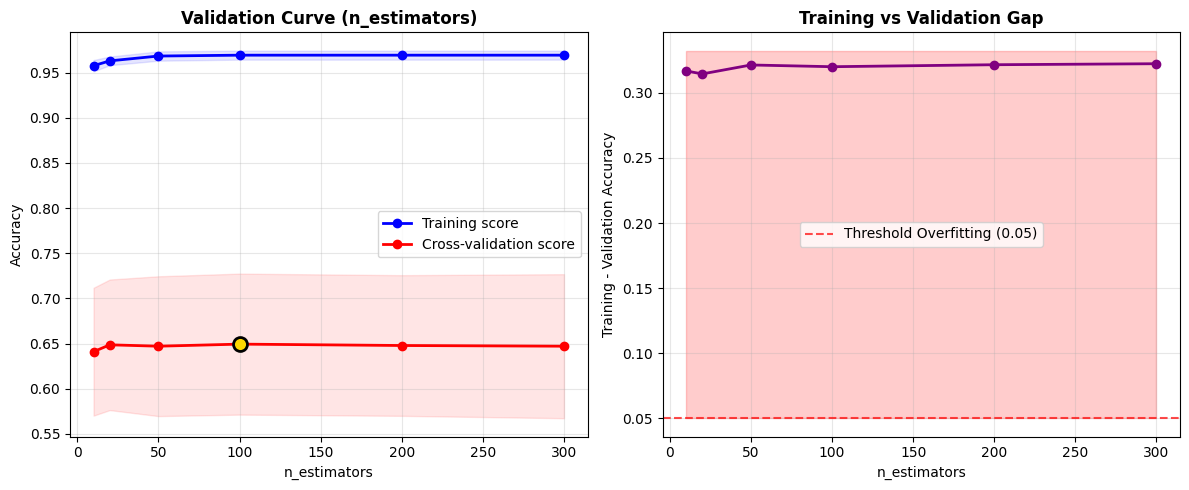

In [ ]:
# -----------------------------------------------------------------------------
# 4.4 CURVAS DE VALIDACIÓN
# -----------------------------------------------------------------------------
print("\n" + "-"*30)
print("4.4 CURVAS DE VALIDACIÓN")
print("-"*30)

print("Las curvas de validación muestran cómo cambia el rendimiento")
print("al variar un hiperparámetro específico")

# Ejemplo con Random Forest y n_estimators
param_range = [10, 20, 50, 100, 200, 300]
print(f"Analizando n_estimators en Random Forest: {param_range}")

print("Calculando curvas de validación...")
train_scores, val_scores = validation_curve(
    RandomForestClassifier(random_state=42),
    X, y, param_name='n_estimators', param_range=param_range,
    cv=5, scoring='accuracy'
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

print("\nResultados de Curva de Validación:")
print("n_estimators | Train Score (±std) | Val Score (±std)   | Gap     | Status")
print("-" * 75)

for i, n_est in enumerate(param_range):
    gap = train_mean[i] - val_mean[i]
    if gap > 0.05:
        status = "⚠️ Overfitting"
    elif gap < -0.02:
        status = "⚡ Underfitting"
    else:
        status = "✅ Balanced"

    print(f"{n_est:11d} | {train_mean[i]:6.4f} (±{train_std[i]:.3f}) | {val_mean[i]:6.4f} (±{val_std[i]:.3f}) | {gap:7.4f} | {status}")

# Encontrar el mejor parámetro
best_idx = np.argmax(val_mean)
best_n_estimators = param_range[best_idx]
print(f"\nMejor n_estimators: {best_n_estimators} (Val accuracy: {val_mean[best_idx]:.4f})")

# Visualización de curvas de validación
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(param_range, train_mean, 'o-', color='blue', label='Training score', linewidth=2)
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(param_range, val_mean, 'o-', color='red', label='Cross-validation score', linewidth=2)
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.title('Validation Curve (n_estimators)', fontweight='bold')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Marcar el mejor punto
plt.scatter(best_n_estimators, val_mean[best_idx], color='gold', s=100, zorder=5,
           edgecolors='black', linewidth=2, label=f'Best: {best_n_estimators}')

plt.subplot(1, 2, 2)
# Gap entre training y validation
gap = train_mean - val_mean
plt.plot(param_range, gap, 'o-', color='purple', linewidth=2)
plt.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='Threshold Overfitting (0.05)')
plt.title('Training vs Validation Gap', fontweight='bold')
plt.xlabel('n_estimators')
plt.ylabel('Training - Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Sombrear zona de overfitting
plt.fill_between(param_range, 0.05, max(gap) + 0.01, alpha=0.2, color='red', label='Overfitting Zone')

plt.tight_layout()
plt.show()

### Metricas de evaluación de los modelos



In [ ]:
# -----------------------------------------------------------------------------
# 5.1 MÉTRICAS COMPLETAS
# -----------------------------------------------------------------------------
print("\n" + "-"*30)
print("5.1 MÉTRICAS COMPLETAS")
print("-"*30)

print("Entrenando modelos finales para evaluación completa...")

# Entrenar modelos con mejores hiperparámetros encontrados
final_models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=best_n_estimators, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

if xgboost_available:
    final_models['XGBoost'] = xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')

if lightgbm_available:
    final_models['LightGBM'] = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)

print("\nMétricas de Evaluación por Modelo:")
print("=" * 60)

metrics_results = {}

for name, model in final_models.items():
    print(f"\nEntrenando {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Obtener probabilidades para ROC-AUC
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = None

    # Calcular métricas
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }

    if y_pred_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
    else:
        metrics['roc_auc'] = None

    metrics_results[name] = metrics

    print(f"{name} - Métricas:")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1-Score:  {metrics['f1']:.4f}")
    if metrics['roc_auc'] is not None:
        print(f"  ROC-AUC:   {metrics['roc_auc']:.4f}")
    else:
        print(f"  ROC-AUC:   No disponible")

# Comparación final
print("\n" + "-"*60)
print("TABLA COMPARATIVA DE MÉTRICAS")
print("-"*60)
print("Modelo           | Accuracy | Precision | Recall  | F1-Score | ROC-AUC")
print("-" * 70)

for name, metrics in metrics_results.items():
    roc_str = f"{metrics['roc_auc']:.4f}" if metrics['roc_auc'] is not None else "  N/A  "
    print(f"{name:15s} | {metrics['accuracy']:8.4f} | {metrics['precision']:9.4f} | {metrics['recall']:7.4f} | {metrics['f1']:8.4f} | {roc_str}")



------------------------------
5.1 MÉTRICAS COMPLETAS
------------------------------
Entrenando modelos finales para evaluación completa...

Métricas de Evaluación por Modelo:

Entrenando Decision Tree...
Decision Tree - Métricas:
  Accuracy:  0.8282
  Precision: 0.8571
  Recall:    0.6600
  F1-Score:  0.7458
  ROC-AUC:   0.8726

Entrenando Random Forest...
Random Forest - Métricas:
  Accuracy:  0.7824
  Precision: 0.7129
  Recall:    0.7200
  F1-Score:  0.7164
  ROC-AUC:   0.8590

Entrenando Gradient Boosting...
Gradient Boosting - Métricas:
  Accuracy:  0.8130
  Precision: 0.7931
  Recall:    0.6900
  F1-Score:  0.7380
  ROC-AUC:   0.8849

Entrenando XGBoost...
XGBoost - Métricas:
  Accuracy:  0.7977
  Precision: 0.7423
  Recall:    0.7200
  F1-Score:  0.7310
  ROC-AUC:   0.8723

Entrenando LightGBM...
LightGBM - Métricas:
  Accuracy:  0.8244
  Precision: 0.7755
  Recall:    0.7600
  F1-Score:  0.7677
  ROC-AUC:   0.8866

------------------------------------------------------------


In [ ]:
# -----------------------------------------------------------------------------
# 5.2 MATRIZ DE CONFUSIÓN DETALLADA
# -----------------------------------------------------------------------------
print("\n" + "-"*40)
print("5.2 ANÁLISIS DE MATRIZ DE CONFUSIÓN")
print("-"*40)

# Usar el mejor modelo para análisis detallado
best_model_name = max(metrics_results.keys(), key=lambda x: metrics_results[x]['accuracy'])
best_model = final_models[best_model_name]

print(f"Analizando matriz de confusión para: {best_model_name}")
print(f"(Mejor modelo por accuracy: {metrics_results[best_model_name]['accuracy']:.4f})")

# Entrenar si no está entrenado
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_best)

print("\nMatriz de Confusión:")
print("                    Predicho")
print("                 No Sobr. | Sobr.")
print("              +----------+----------+")
print(f"Real No Sobr. |   {cm[0,0]:4d}   |   {cm[0,1]:4d}   |")
print("              +----------+----------+")
print(f"     Sobr.    |   {cm[1,0]:4d}   |   {cm[1,1]:4d}   |")
print("              +----------+----------+")

# Desglose de la matriz
tn, fp, fn, tp = cm.ravel()

print(f"\nDesglose de Predicciones:")
print(f"  Verdaderos Negativos (TN): {tn} - Correctamente predijo 'No Sobrevivió'")
print(f"  Falsos Positivos (FP):     {fp} - Incorrectamente predijo 'Sobrevivió'")
print(f"  Falsos Negativos (FN):     {fn} - Incorrectamente predijo 'No Sobrevivió'")
print(f"  Verdaderos Positivos (TP): {tp} - Correctamente predijo 'Sobrevivió'")

# Métricas calculadas manualmente desde la matriz
accuracy_manual = (tp + tn) / (tp + tn + fp + fn)
precision_manual = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_manual = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
f1_manual = 2 * (precision_manual * recall_manual) / (precision_manual + recall_manual) if (precision_manual + recall_manual) > 0 else 0

print(f"\nMétricas Calculadas desde la Matriz:")
print(f"  Accuracy =    (TP + TN) / Total           = ({tp} + {tn}) / {tp + tn + fp + fn} = {accuracy_manual:.4f}")
print(f"  Precision =   TP / (TP + FP)              = {tp} / ({tp} + {fp}) = {precision_manual:.4f}")
print(f"  Recall =      TP / (TP + FN)              = {tp} / ({tp} + {fn}) = {recall_manual:.4f}")
print(f"  Specificity = TN / (TN + FP)              = {tn} / ({tn} + {fp}) = {specificity:.4f}")
print(f"  F1-Score =    2 * (Prec * Rec)/(Prec+Rec) = 2 * ({precision_manual:.4f} * {recall_manual:.4f})/({precision_manual:.4f}+{recall_manual:.4f}) = {f1_manual:.4f}")


----------------------------------------
5.2 ANÁLISIS DE MATRIZ DE CONFUSIÓN
----------------------------------------
Analizando matriz de confusión para: Decision Tree
(Mejor modelo por accuracy: 0.8282)

Matriz de Confusión:
                    Predicho
                 No Sobr. | Sobr.
              +----------+----------+
Real No Sobr. |    151   |     11   |
              +----------+----------+
     Sobr.    |     34   |     66   |
              +----------+----------+

Desglose de Predicciones:
  Verdaderos Negativos (TN): 151 - Correctamente predijo 'No Sobrevivió'
  Falsos Positivos (FP):     11 - Incorrectamente predijo 'Sobrevivió'
  Falsos Negativos (FN):     34 - Incorrectamente predijo 'No Sobrevivió'
  Verdaderos Positivos (TP): 66 - Correctamente predijo 'Sobrevivió'

Métricas Calculadas desde la Matriz:
  Accuracy =    (TP + TN) / Total           = (66 + 151) / 262 = 0.8282
  Precision =   TP / (TP + FP)              = 66 / (66 + 11) = 0.8571
  Recall =      TP / (TP 

In [ ]:
# -----------------------------------------------------------------------------
# 5.3 REPORTE DE CLASIFICACIÓN COMPLETO
# -----------------------------------------------------------------------------
print("\n" + "-"*40)
print("5.3 REPORTE DE CLASIFICACIÓN COMPLETO")
print("-"*40)

# Reporte detallado con nombres de clases
class_names = ['No Sobrevivió', 'Sobrevivió']
report = classification_report(y_test, y_pred_best, target_names=class_names)
print(report)

print("\n📊 INTERPRETACIÓN DE MÉTRICAS:")
print("─" * 50)
print("🎯 PRECISION: De todos los casos que predijimos como positivos,")
print("   ¿qué porcentaje eran realmente positivos?")
print("   → Importante cuando el costo de falsos positivos es alto")

print("\n🔍 RECALL (Sensibilidad): De todos los casos realmente positivos,")
print("   ¿qué porcentaje identificamos correctamente?")
print("   → Importante cuando el costo de falsos negativos es alto")

print("\n⚖️ F1-SCORE: Media armónica entre precision y recall")
print("   → Útil cuando queremos balancear precision y recall")

print("\n📈 SUPPORT: Número de casos reales de cada clase en el conjunto de test")
print("   → Indica si tenemos suficientes ejemplos para evaluar confiablemente")

print("\n🎪 MACRO AVG: Promedio simple de métricas por clase")
print("   → Trata todas las clases por igual, útil para clases balanceadas")

print("\n⚡ WEIGHTED AVG: Promedio ponderado por el número de ejemplos por clase")
print("   → Considera el desbalance de clases, más representativo del rendimiento general")



----------------------------------------
5.3 REPORTE DE CLASIFICACIÓN COMPLETO
----------------------------------------
               precision    recall  f1-score   support

No Sobrevivió       0.82      0.93      0.87       162
   Sobrevivió       0.86      0.66      0.75       100

     accuracy                           0.83       262
    macro avg       0.84      0.80      0.81       262
 weighted avg       0.83      0.83      0.82       262


📊 INTERPRETACIÓN DE MÉTRICAS:
──────────────────────────────────────────────────
🎯 PRECISION: De todos los casos que predijimos como positivos,
   ¿qué porcentaje eran realmente positivos?
   → Importante cuando el costo de falsos positivos es alto

🔍 RECALL (Sensibilidad): De todos los casos realmente positivos,
   ¿qué porcentaje identificamos correctamente?
   → Importante cuando el costo de falsos negativos es alto

⚖️ F1-SCORE: Media armónica entre precision y recall
   → Útil cuando queremos balancear precision y recall

📈 SUPPORT: N

In [ ]:
# -----------------------------------------------------------------------------
# 5.4 ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS
# -----------------------------------------------------------------------------
print("\n" + "-"*40)
print("5.4 IMPORTANCIA DE CARACTERÍSTICAS")
print("-"*40)

if hasattr(best_model, 'feature_importances_'):
    print(f"Analizando importancia de características en {best_model_name}...")

    feature_importance = best_model.feature_importances_
    feature_names = X.columns

    # Crear dataframe para ordenar
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    print("\nImportancia de Características (ordenado por importancia):")
    print("Característica     | Importancia | Porcentaje")
    print("-" * 45)

    total_importance = importance_df['importance'].sum()
    for idx, row in importance_df.iterrows():
        percentage = (row['importance'] / total_importance) * 100
        print(f"{row['feature']:17s} | {row['importance']:11.4f} | {percentage:8.2f}%")

    # Características más importantes
    top_3 = importance_df.head(3)
    print(f"\n🏆 TOP 3 características más importantes:")
    for idx, row in top_3.iterrows():
        percentage = (row['importance'] / total_importance) * 100
        print(f"   {idx+1}. {row['feature']} ({percentage:.1f}%)")
else:
    print(f"{best_model_name} no proporciona importancia de características")


----------------------------------------
5.4 IMPORTANCIA DE CARACTERÍSTICAS
----------------------------------------
Analizando importancia de características en Decision Tree...

Importancia de Características (ordenado por importancia):
Característica     | Importancia | Porcentaje
---------------------------------------------
sex               |      0.5483 |    54.83%
pclass            |      0.1737 |    17.37%
age               |      0.1238 |    12.38%
fare              |      0.0822 |     8.22%
sibsp             |      0.0694 |     6.94%
parch             |      0.0017 |     0.17%
embarked          |      0.0010 |     0.10%

🏆 TOP 3 características más importantes:
   2. sex (54.8%)
   1. pclass (17.4%)
   3. age (12.4%)


### Conclusión, resumen y recomendaciones



In [ ]:
print("\n" + "="*60)
print("📋 RESUMEN FINAL Y RECOMENDACIONES")
print("="*60)

# Encontrar el mejor modelo por cada métrica
best_by_metric = {}
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    best_by_metric[metric] = max(metrics_results.keys(),
                                key=lambda x: metrics_results[x][metric])

print("\n🏅 MEJORES MODELOS POR MÉTRICA:")
print(f"  • Accuracy:  {best_by_metric['accuracy']} ({metrics_results[best_by_metric['accuracy']]['accuracy']:.4f})")
print(f"  • Precision: {best_by_metric['precision']} ({metrics_results[best_by_metric['precision']]['precision']:.4f})")
print(f"  • Recall:    {best_by_metric['recall']} ({metrics_results[best_by_metric['recall']]['recall']:.4f})")
print(f"  • F1-Score:  {best_by_metric['f1']} ({metrics_results[best_by_metric['f1']]['f1']:.4f})")

# Modelo más consistente (menor variación en ranking)
model_ranks = {}
for model_name in metrics_results.keys():
    ranks = []
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        # Obtener ranking de este modelo para esta métrica
        sorted_models = sorted(metrics_results.keys(),
                             key=lambda x: metrics_results[x][metric], reverse=True)
        rank = sorted_models.index(model_name) + 1
        ranks.append(rank)

    model_ranks[model_name] = {
        'avg_rank': np.mean(ranks),
        'rank_std': np.std(ranks),
        'ranks': ranks
    }

most_consistent = min(model_ranks.keys(), key=lambda x: model_ranks[x]['rank_std'])
best_overall = min(model_ranks.keys(), key=lambda x: model_ranks[x]['avg_rank'])

print(f"\n🎯 MODELO MÁS CONSISTENTE: {most_consistent}")
print(f"   (Menor variación entre rankings: {model_ranks[most_consistent]['rank_std']:.2f})")

print(f"\n🥇 MEJOR MODELO GENERAL: {best_overall}")
print(f"   (Menor ranking promedio: {model_ranks[best_overall]['avg_rank']:.2f})")

print(f"\n📈 TÉCNICAS MÁS EFECTIVAS ENCONTRADAS:")
if 'lasso_results' in locals():
    print(f"  • Mejor regularización L1 (C): {best_l1['C']}")
if 'ridge_results' in locals():
    print(f"  • Mejor regularización L2 (C): {best_l2['C']}")
if 'best_n_estimators' in locals():
    print(f"  • Óptimo n_estimators: {best_n_estimators}")

print(f"\n💡 RECOMENDACIONES:")
print(f"  1. Usar {best_overall} como modelo principal")
print(f"  2. Aplicar validación cruzada estratificada (dataset desbalanceado)")
print(f"  3. Monitorear overfitting con learning curves")
if hasattr(best_model, 'feature_importances_'):
    top_feature = importance_df.iloc[0]['feature']
    print(f"  4. La característica '{top_feature}' es la más importante")
print(f"  5. Considerar ensemble de los mejores modelos para mayor robustez")

print(f"\n✅ ANÁLISIS COMPLETO FINALIZADO")
print("="*60)


📋 RESUMEN FINAL Y RECOMENDACIONES

🏅 MEJORES MODELOS POR MÉTRICA:
  • Accuracy:  Decision Tree (0.8282)
  • Precision: Decision Tree (0.8571)
  • Recall:    LightGBM (0.7600)
  • F1-Score:  LightGBM (0.7677)

🎯 MODELO MÁS CONSISTENTE: XGBoost
   (Menor variación entre rankings: 0.43)

🥇 MEJOR MODELO GENERAL: LightGBM
   (Menor ranking promedio: 1.75)

📈 TÉCNICAS MÁS EFECTIVAS ENCONTRADAS:
  • Mejor regularización L1 (C): 1
  • Mejor regularización L2 (C): 0.01
  • Óptimo n_estimators: 100

💡 RECOMENDACIONES:
  1. Usar LightGBM como modelo principal
  2. Aplicar validación cruzada estratificada (dataset desbalanceado)
  3. Monitorear overfitting con learning curves
  4. La característica 'sex' es la más importante
  5. Considerar ensemble de los mejores modelos para mayor robustez

✅ ANÁLISIS COMPLETO FINALIZADO
